In [27]:
import torch
from torch import nn
from torchrl.modules import Actor
from torchrl.envs import GymEnv
from torchrl.envs import R3MTransform, TransformedEnv
from tensordict.nn import TensorDictSequential
from torchrl.data import LazyMemmapStorage, ReplayBuffer

import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Default device is {device}")

Default device is cpu


In [3]:
base_env = GymEnv(
    env_name="Ant-v4", from_pixels=True, pixels_only=False, device=device
)

In [4]:
td = base_env.reset()

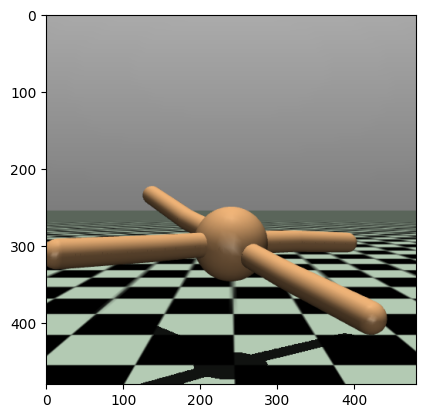

In [8]:
img = td['pixels']
plt.imshow(img)

In [15]:
r3m = R3MTransform(
    model_name="resnet50",
    in_keys=["pixels"],
    download=True
)

env_transformed = TransformedEnv(env=base_env, transform=r3m)

net = nn.Sequential(
    nn.LazyLinear(128, device=device),
    nn.Tanh(),
    nn.Linear(128, base_env.action_spec.shape[-1], device=device),
)

mlp_policy = Actor(module=net, in_keys=['r3m_vec'])

In [16]:
print("number of params:", len(list(mlp_policy.parameters())))

number of params: 4


In [17]:
rollout = env_transformed.rollout(max_steps=32, policy=mlp_policy)
print("rollout with transform:", rollout)

rollout with transform: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([32, 8]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([32, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([32, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([32, 27]), device=cpu, dtype=torch.float64, is_shared=False),
                r3m_vec: Tensor(shape=torch.Size([32, 2048]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([32, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([32, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([32, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([32]),
     

In [19]:
r3m.train(mode=True)
policy = TensorDictSequential(r3m, mlp_policy)
print(
    "number of params after r3m is integrated:", 
    len(list(policy.parameters()))
)

number of params after r3m is integrated: 163


In [22]:
rollout = base_env.rollout(max_steps=32, policy=policy)
print("rollout, fine tuning:", rollout)

rollout, fine tuning: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([32, 8]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([32, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([32, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([32, 27]), device=cpu, dtype=torch.float64, is_shared=False),
                pixels: Tensor(shape=torch.Size([32, 480, 480, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                reward: Tensor(shape=torch.Size([32, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([32, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([32, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([32]),
   

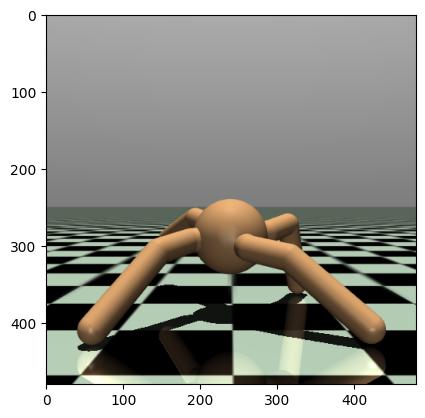

In [ ]:
img = rollout['next', 'pixels']
plt.imshow(img[20])

In [28]:
storage = LazyMemmapStorage(max_size=1000)
rb = ReplayBuffer(storage=storage, transform=r3m)

In [29]:
total = 0
while total < 1000:
    td = base_env.rollout(1000)
    rb.extend(td)
    total += td.numel()
    print(td.numel(), total)

59 59
194 253
12 265
29 294
25 319
29 348
115 463
251 714
24 738
30 768
194 962
50 1012


In [31]:
print('stored data', storage._storage)

stored data TensorDict(
    fields={
        action: MemoryMappedTensor(shape=torch.Size([1000, 8]), device=cpu, dtype=torch.float32, is_shared=False),
        done: MemoryMappedTensor(shape=torch.Size([1000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: MemoryMappedTensor(shape=torch.Size([1000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: MemoryMappedTensor(shape=torch.Size([1000, 27]), device=cpu, dtype=torch.float64, is_shared=False),
                pixels: MemoryMappedTensor(shape=torch.Size([1000, 480, 480, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                reward: MemoryMappedTensor(shape=torch.Size([1000, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: MemoryMappedTensor(shape=torch.Size([1000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: MemoryMappedTensor(shape=torch.Size([10

In [32]:
batch = rb.sample(16)
print("data after sampling:", batch)

data after sampling: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([16, 8]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([16, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([16, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([16, 27]), device=cpu, dtype=torch.float64, is_shared=False),
                pixels: Tensor(shape=torch.Size([16, 480, 480, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                reward: Tensor(shape=torch.Size([16, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([16, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([16, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([16]),
    